<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q2
    Instructor: Kris                          TAs: Wen-Hsuan (Lead), Zen, Yan, Rawal, Paritosh, Qichen

In [1]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q2: Matthew-Bakers Inverse Compositional Alignment with Affine Matrix

### Q2.1: Implementation (10 PT write-up, 20 PT implementation)
Now we will implement the Matthew-Bakers tracker to alleviate the computational costs of the the Lucas-Kanade tracker, as it only calculates the Hessian and Jacobian once per each video. Write the function with the following function signature:

```
            M = InverseCompositionAffine(It, It1, rect)
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$ that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to Q1.2, but you should replace the forward alignment algorithm with the inverse compositional alignment algorithm. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code. Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do they have those differences? At what point does the algorithm break down and why does this happen?

In [2]:
def make_M(P):
    M = P.copy()
    M[0, 0] += 1
    M[1, 1] += 1
    return M


def inverse_warp(P):
    # Note! These are not sequential because of the parameter order
    p1, p3, p5, p2, p4, p6 = P.flatten()

    scalar = 1 / ((1 + p1) * (1 + p4) - p2*p3)
    return scalar * np.array([
        -p1 - p1*p4 + p2*p3,
        -p2,
        -p3,
        -p4 - p1*p4 + p2*p3,
        -p5 - p4*p5 + p3*p6,
        -p6 - p1*p6 + p2*p5,
    ])


def update_warp(P, delta_P_vector):

    # Note! These are not sequential because of the parameter order
    p1, p3, p5, p2, p4, p6 = P.flatten()

    d1, d2, d3, d4, d5, d6 = inverse_warp(delta_P_vector)
    n1, n2, n3, n4, n5, n6 = np.array([
        p1 + d1 + p1*d1 + p3*d2,
        p2 + d2 + p2*d1 + p4*d2,
        p3 + d3 + p1*d3 + p3*d4,
        p4 + d4 + p2*d3 + p4*d4,
        p5 + d5 + p1*d5 + p3*d6,
        p6 + d6 + p2*d5 + p4*d6,
    ])
    return np.array([
        [n1, n3, n5],
        [n2, n4, n6],
    ])


def test_update_warp(M, delta_P_vector):
    newM = np.vstack((M, np.array([0, 0, 1])))
    d1, d2, d3, d4, d5, d6 = delta_P_vector
    deltaP = np.array([
        [1 + d1, d3, d5],
        [d2, 1 + d4, d6],
        [0, 0, 1],
    ])
    return (newM @ np.linalg.pinv(deltaP))[:2]

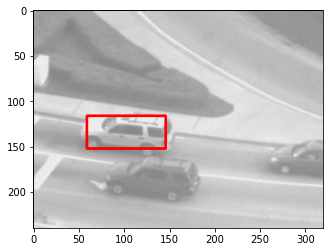

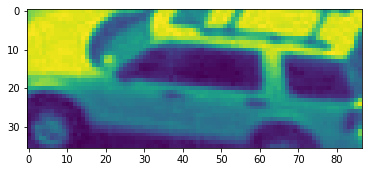

[[ 9.99685957e-01 -4.04944486e-05  1.00584500e+00]
 [ 2.72002587e-04  9.99622768e-01  8.96179722e-01]] is close to 
[[1 0 1]
 [0 1 1]]? False


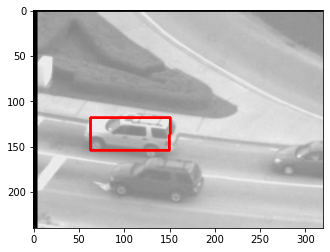

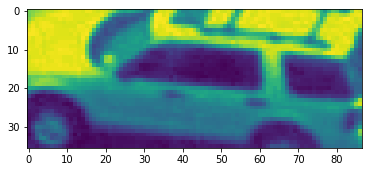

[[ 1.00166928e+00 -3.85898267e-03  5.31965472e+00]
 [ 6.01366703e-04  9.99174674e-01  2.09715939e+00]] is close to 
[[1 0 5]
 [0 1 2]]? False


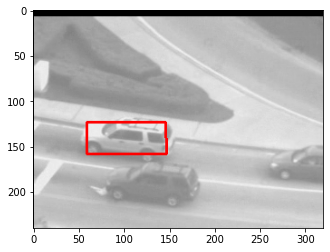

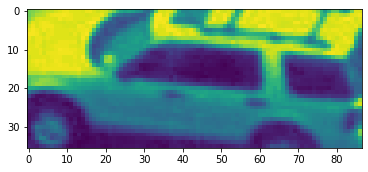

[[1.00028703e+00 1.86046206e-03 6.86157239e-01]
 [1.49581291e-03 9.94853244e-01 7.55078211e+00]] is close to 
[[1 0 1]
 [0 1 7]]? False


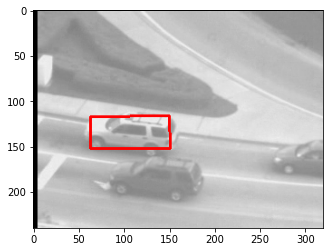

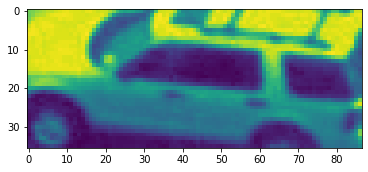

[[ 1.00135406e+00  4.04592576e-03  4.24608172e+00]
 [-1.39150427e-03  9.97326961e-01  1.46202337e+00]] is close to 
[[1 0 5]
 [0 1 1]]? False


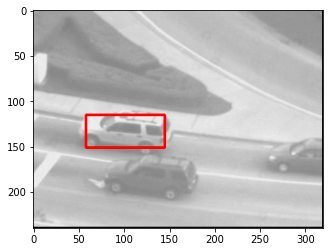

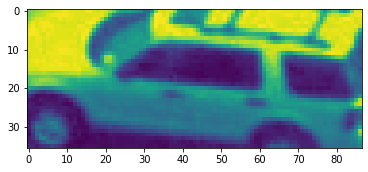

[[ 1.00030328e+00 -1.03763582e-04 -9.88501468e-01]
 [-2.79673429e-04  1.00048908e+00 -9.08470931e-01]] is close to 
[[ 1  0 -1]
 [ 0  1 -1]]? False


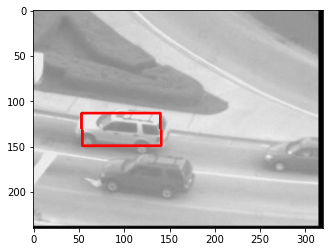

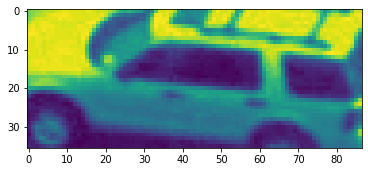

[[ 9.99679533e-01  4.92532505e-03 -5.55256989e+00]
 [-4.18907379e-04  1.00161677e+00 -2.23441182e+00]] is close to 
[[ 1  0 -5]
 [ 0  1 -2]]? False


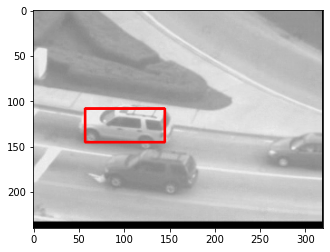

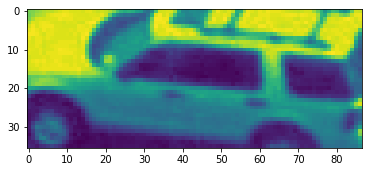

[[ 1.00107813e+00  1.73088768e-03 -1.33268632e+00]
 [-1.01119558e-03  1.00586146e+00 -7.71179673e+00]] is close to 
[[ 1  0 -1]
 [ 0  1 -7]]? False


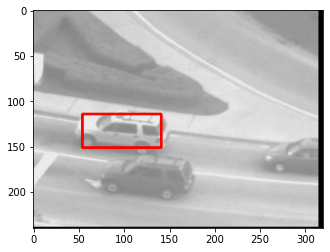

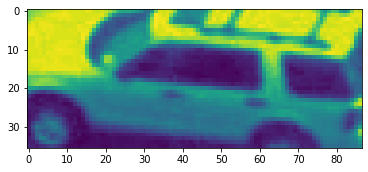

[[ 9.99474369e-01 -3.02429902e-03 -4.44113917e+00]
 [ 1.59816801e-04  1.00253737e+00 -1.32904630e+00]] is close to 
[[ 1  0 -5]
 [ 0  1 -1]]? False


In [6]:
import nbimporter
from q1 import affine_warp, plot_impoly


def InverseCompositionAffine(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q2.1: Matthew-Bakers Inverse Compositional Alignment with Affine Matrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine matrix (2x3)
    '''
    
    # Set thresholds (you probably want to play around with the values)
    P = np.zeros((2,3))
    threshold = thresh
    maxIters = maxIt
    x1, y1, x2, y2 = rect
    
    # ----- TODO -----
    # YOUR CODE HERE

    M = P.copy()
    np.fill_diagonal(M, 1)
    
    # Pre-create splines for both images, for speed reasons. Taking
    # the full-image spline is expensive
    # Importantly, although we are interpreting x as horizontal and y as vertical,
    # RectBivariateSpline does not. Hence when given image we set x=shape[0] and
    # y=shape[1]
    template_spline = RectBivariateSpline(x=np.array(range(It.shape[0])),
                                          y=np.array(range(It.shape[1])),
                                          z=It)
    image_spline = RectBivariateSpline(x=np.array(range(It1.shape[0])),
                                       y=np.array(range(It1.shape[1])),
                                       z=It1)

    # Get the template patch and gradients once
    template, template_Ix, template_Iy, template_x, template_y = \
        affine_warp(template_spline, M=M, rect=rect, image=It)
        # affine_warp(template_spline, M=make_M(P), rect=rect, image=It)
    template_Ix = template_Ix.flatten()
    template_Iy = template_Iy.flatten()

    # Optional visualization
    # plt.imshow(template); plt.title("Template"); plt.show()
    # plt.imshow(template_Ix.reshape(template.shape)); plt.title("template_Ix"); plt.show()
    # plt.imshow(template_Ix.reshape(template.shape)); plt.title("template_Ix"); plt.show()

    # Get the steepest descent images 
    grad_T_dWdp = np.vstack((template_Ix * template_x,
                             template_Iy * template_x,
                             template_Ix * template_y,
                             template_Iy * template_y,
                             template_Ix,
                             template_Iy)).T
    
    # Get the Hessian (note that the transpose order is opposite of
    # the paper, that's because grad_T_dWdp was naturally a big row,
    # and so big row @ big column = the 6x6 we want). Doing pinv for
    # robustness
    hessian = grad_T_dWdp.T @ grad_T_dWdp
    inv_hessian = np.linalg.pinv(hessian)

    for i in range(maxIters):
        # Get warps with the new M
        warped_patch, _, _, _, _ = \
            affine_warp(image_spline, M, rect, It1, compute_gradients=False)
            # affine_warp(image_spline, make_M(P), rect, It1, compute_gradients=False)
        
        # Optional visualization
        # if i % 10 == 0:
        #     print(i, P, M)
        #     plt.imshow(warped_patch); plt.title("warped_patch"); plt.show()

        # Get the I(W(x, p)) - T(x) term
        error = warped_patch.flatten() - template.flatten()
        
        # Do the sum of J*b. J is (6, N) so when we sum we get shape (6,)
        sum_vector = grad_T_dWdp.T @ error
        
        # Then compute delta P using equation 19
        delta_P_vector = inv_hessian @ sum_vector

        # Update the warp parameters
        # P = update_warp(P, delta_P_vector)
        # import ipdb; ipdb.set_trace()
        M = test_update_warp(M, delta_P_vector)

        if np.linalg.norm(delta_P_vector) < threshold:
            break

    # Visualization plots
    # plot_impoly(It1, rect, make_M(P))
    # TEMP, _, _, _, _ = affine_warp(image_spline, make_M(P), rect, It1); plt.imshow(TEMP); plt.show()
    # return make_M(P)
    plot_impoly(It1, rect, M)
    TEMP, _, _, _, _ = affine_warp(image_spline, M, rect, It1); plt.imshow(TEMP); plt.show()
    return M


# Explore for a shifted image
data_name = "car2"
data = np.load('./data/%s.npy' % data_name)
initial = np.array([59, 116, 145, 151])
numFrames = data.shape[2]
It = data[:,:,0]
def translate_M(p0, p1):
    return np.array([[1, 0, p1], [0, 1, p0]])

# MUCH MORE SENSITIVE THAN THE TRANSLATION VERSION
# Construct a modified It as It1 for different positive offsets
for p0, p1 in ((1, 1), (2, 5), (7, 1), (1, 5)):
    if p0 == 0 or p1 == 0:
        It1 = It.copy()
    else:
        It1 = np.zeros(It.shape, dtype=np.uint8)
        It1[p0:, p1:] = It[:-p0, :-p1]
    # THEN call image alignment on it
    calc_M = InverseCompositionAffine(It, It1, initial)
    print(f"{calc_M} is close to \n{translate_M(p0, p1)}? {np.allclose(calc_M, translate_M(p0, p1))}")
# Again for negatives?
for p0, p1 in ((-1, -1), (-2, -5), (-7, -1), (-1, -5)):
    It1 = np.zeros(It.shape, dtype=np.uint8)
    It1[:p0, :p1] = It[-p0:, -p1:]
    # THEN call image alignment on it
    calc_M = InverseCompositionAffine(It, It1, initial)
    print(f"{calc_M} is close to \n{translate_M(p0, p1)}? {np.allclose(calc_M, translate_M(p0, p1))}")

In [4]:
# Test your algorithm and visualize results!

# Load data
for data_name in ["car1", "car2", "landing", "race", "ballet"]:
    print(f"\n{data_name}")
    data = np.load('./data/%s.npy' % data_name)

    # obtain the initial rect with format (x1, y1, x2, y2)
    if data_name == 'car1':
        initial = np.array([170, 130, 290, 250])
    elif data_name == 'car2':
        initial = np.array([59, 116, 145, 151])
    elif data_name == 'landing':
        initial = np.array([440, 80, 560, 140])
    elif data_name == 'race':
        initial = np.array([170, 270, 300, 370])
    elif data_name == 'ballet':
        initial = np.array([700, 210, 775, 300])
    else:
        assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

    numFrames = data.shape[2]
    w = initial[2] - initial[0]
    h = initial[3] - initial[1]

    # loop over frames
    rects = []
    rects.append(initial)

    for i in range(numFrames-1):

        It = data[:,:,i]
        It1 = data[:,:,i+1]
        rect = rects[i]

        # run algorithm and collect rects
        M = InverseCompositionAffine(It, It1, rect)
        corners = np.array([[rect[0], rect[1], 1], 
                            [rect[2], rect[3], 1]]).transpose()
        newRect = np.matmul(M, corners).transpose().reshape((4, ))
        rects.append(newRect)

        # Visualize
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
        plt.imshow(It1, cmap='gray')
        # plt.show()
        # ax.clear()
        plt.savefig(f"./vis/{data_name}_{i}.png")
        plt.close(fig)
        print(f"{i} ", end="")


car1
> <ipython-input-3-499826330978>(80)InverseCompositionAffine()
     79 
---> 80         delta_M = np.array([
     81             [delta_M_vector[0], delta_M_vector[2], delta_M_vector[4]],

ipdb> grad_T_dWdp
array([[-2.87420618e+02, -2.19852943e+02,  1.43356570e+02, ...,
        -1.52781569e+03,  2.87898096e+01, -3.17132197e+02],
       [-8.26510359e+01, -1.16122373e+02, -3.65548329e+01, ...,
        -4.34418199e+03, -3.63264559e+03, -2.47371561e+03],
       [-2.19792238e+02, -1.67139665e+02,  1.08350896e+02, ...,
        -1.32622889e+03,  2.49046796e+01, -2.73389825e+02],
       [-6.32037333e+01, -8.82801664e+01, -2.76286528e+01, ...,
        -3.77099131e+03, -3.14242698e+03, -2.13251346e+03],
       [-1.69070952e+00, -1.28568973e+00,  8.33468431e-01, ...,
        -5.30491557e+00,  9.96187183e-02, -1.09355930e+00],
       [-4.86182564e-01, -6.79078203e-01, -2.12528098e-01, ...,
        -1.50839653e+01, -1.25697079e+01, -8.53005384e+00]])
ipdb> grad_T_dWdp.shape
(6, 14641)
ipdb> e

BdbQuit: 

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q2.2: Comparing Your Algorithms (write-up only, 10 PT)
Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do we have those differences?  At what point does the algorithm break down and why does this happen?